## Семинар 15: "Обучение с подкреплением 2"

ФИО: Дорожинский Владислав Игоревич

###  FrozenLake


<img src="http://vignette2.wikia.nocookie.net/riseoftheguardians/images/4/4c/Jack's_little_sister_on_the_ice.jpg/revision/latest?cb=20141218030206" alt="a random image to attract attention" style="width: 400px;"/>



In [2]:
import gym
import numpy as np 
import random
import cv2
from torch import nn
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
from collections import deque
import time

In [ ]:
#create a single game instance
env = gym.make("FrozenLake-v0")

#start new game
env.reset();

In [2]:
# display the game state
env.render()


SFFF
FHFH
FFFH
HFFG


### legend

![img](https://cdn-images-1.medium.com/max/800/1*MCjDzR-wfMMkS0rPqXSmKw.png)

## Задание 1.
Подберите значения alpha и epsilon и найдите приближение оптимальной Q-функции для Frozen Lake.

In [133]:

class QLearn:
    def __init__(self, actions, epsilon=0.1, alpha=0.2, gamma=0.9):
        self.q = {}
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.actions = actions

    def getQ(self, state, action):
        return self.q.get((state, action), 0.0)

    def learnQ(self, state, action, reward, value):
        oldv = self.q.get((state, action), None)

        if oldv is None:
            self.q[(state, action)] = reward
        else:
            self.q[(state, action)] = oldv + self.alpha * (value - oldv)

    def chooseAction(self, state, is_eval=False):
        if random.random() < self.epsilon and not is_eval:
            action = random.choice(self.actions)
        else:
            q = [self.getQ(state, a) for a in self.actions]
            maxQ = max(q)
            count = q.count(maxQ)
            if count > 1:
                best = [i for i in range(len(self.actions)) if q[i] == maxQ]
                i = random.choice(best)
            else:
                i = q.index(maxQ)

            action = self.actions[i]
        return action

    def learn(self, state1, action1, reward, state2):
        maxqnew = max([self.getQ(state2, a) for a in self.actions])
        self.learnQ(state1, action1, reward, reward + self.gamma*maxqnew)

In [134]:
def run_episode_qlearn_learn(env, qlearn, gamma=1.0, render=False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        action = qlearn.chooseAction(obs)
        obs_new, reward, done, _ = env.step(action)
        qlearn.learn(obs, action, reward, obs_new)
        obs = obs_new
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

In [136]:
def run_episode_qlearn(env, qlearn, gamma=1.0, render=False):
    obs = env.reset()
    total_reward = 0
    step_idx = 0
    while True:
        if render:
            env.render()
        action = qlearn.chooseAction(obs, is_eval=True)
        obs_new, reward, done, _ = env.step(action)
        obs = obs_new
        total_reward += (gamma ** step_idx * reward)
        step_idx += 1
        if done:
            break
    return total_reward

In [137]:
def evaluate_qlearn(env, qlearn, gamma=1.0, n=100):
    scores = [
            run_episode_qlearn(env, qlearn, gamma = gamma, render = False)
            for _ in range(n)]
    return np.mean(scores)

In [168]:
GAMMA = 0.99
qlearn = QLearn(actions=range(env.env.nA), gamma=GAMMA, epsilon=0.1, alpha=0.3)
[run_episode_qlearn_learn(env, qlearn, gamma=GAMMA) for _ in range(1000)];


In [172]:
evaluate_qlearn(env, qlearn, gamma=1.0, n=1000)

0.759

## Задание 2.
Обучите сеть DQN для среды http://gym.openai.com/envs/Pong-v0/ 

* http://www.pinchofintelligence.com/introduction-openai-gym-part-2-building-deep-q-network/
* http://www.pinchofintelligence.com/openai-gym-part-3-playing-space-invaders-deep-reinforcement-learning/
* https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [3]:
env = gym.make('Pong-v0')
env.reset()
actions = env.action_space.n # 0 - idle, 4 - move up, 5 - move down

In [4]:
act_up, act_down, act_idle = 4, 5, 0
actions_mapping = [act_idle, act_up, act_down]

In [5]:
SHORT_MEMORY_SIZE = 4
N_ACTIONS = len(actions_mapping)
IMAGE_DIM = 84

Before processing: (210, 160, 3)


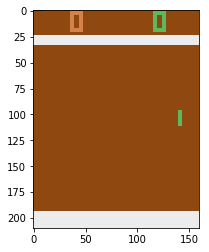

After processing: (84, 84, 1)


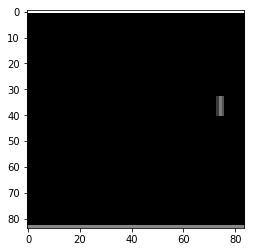

In [6]:
def one_hot(x, n_classes, dtype=np.float64):
    res = np.zeros([x.shape[0], n_classes], dtype=dtype)
    res[np.arange(x.shape[0]), x] = 1
    return res

def preprocess(observation):
    head_cut = 32
    tail_cut = 15
    target_size = IMAGE_DIM
    observation = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
    observation = cv2.resize(observation[head_cut:-tail_cut], (target_size, target_size))
#     ret, observation = cv2.threshold(observation,80,255,cv2.THRESH_BINARY)
    return np.reshape(observation,(target_size,target_size,1))

def show(img):
    plt.imshow(np.array(np.squeeze(img)), cmap='gray')
    plt.show()

action0 = 0  # do nothing
observation0, reward0, terminal, info = env.step(action0)
print("Before processing: " + str(np.array(observation0).shape))
plt.imshow(np.array(observation0))
plt.show()
observation0 = preprocess(observation0)
print("After processing: " + str(np.array(observation0).shape))
show(observation0)


In [7]:
class DQN(nn.Module):
    def __init__(self, in_channels, output_size):
        super(DQN, self).__init__()
        self.features = nn.Sequential(nn.Conv2d(in_channels, 16, 8, stride=4),
                                      nn.BatchNorm2d(16),
                                      nn.ReLU(),
                                      nn.Conv2d(16, 32, 4, stride=2),
                                      nn.BatchNorm2d(32),
                                      nn.ReLU(),
                                     )
        
        self.classifier = nn.Sequential(nn.Linear(32 * 9 * 9, 256),
                                        nn.BatchNorm1d(256),
                                        nn.ReLU(),
                                        nn.Linear(256, output_size)
                                       )
    
    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.features(x)
        x = x.view(-1, 32 * 9 * 9)
        x = self.classifier(x)
        return x

In [19]:
INITIAL_EPSILON = 1.0
FINAL_EPSILON = 0.1
EXPLORE = 10000
REPLAY_MEMORY = 10000
BATCH_SIZE = 128
PRINT_EVERY = 500
GAMMA = 0.95
ALPHA = 1.0
K = 4

class Controller:
    def __init__(self, verbose=False):
        self.epsilon = INITIAL_EPSILON
        self.verbose = verbose
        self.dqn = DQN(SHORT_MEMORY_SIZE, N_ACTIONS).cuda()
        self.optimizer = torch.optim.Adam(self.dqn.parameters(), lr=0.001)
        self.loss_f = nn.MSELoss()
        self.step = 0
        self.replay = deque()
        self.states = deque()
    
        
    def train_step(self):
#         print('>>>ENTER TRAIN STEP')
        self.dqn.train()
        batch_idxs = np.random.randint(SHORT_MEMORY_SIZE, len(self.replay)-1, BATCH_SIZE)
        state_batch = np.zeros([BATCH_SIZE, IMAGE_DIM, IMAGE_DIM, SHORT_MEMORY_SIZE], dtype=np.float32)
        action_batch = np.zeros([BATCH_SIZE], dtype=np.int32)
        term_batch = np.zeros([BATCH_SIZE], dtype=np.int32)
        reward_batch = np.zeros([BATCH_SIZE], dtype=np.float32)
        y_reward_batch = np.zeros([BATCH_SIZE], dtype=np.float32)
        next_state_batch = np.zeros([BATCH_SIZE, IMAGE_DIM, IMAGE_DIM, SHORT_MEMORY_SIZE], dtype=np.float32)
        
        for i in range(BATCH_SIZE): # todo: vectorize
            idx = batch_idxs[i]
            action_batch[i] = self.replay[idx][1]
            reward_batch[i] = self.replay[idx][2]
            term_batch[i] = self.replay[idx][3]
            for j in range(SHORT_MEMORY_SIZE):
                state_batch[i,:,:,j] = self.states[idx - j - 1]
                next_state_batch[i,:,:,j] = self.states[idx - j]
        
        next_state_batch = Variable(torch.FloatTensor(next_state_batch)).cuda()
        reward_batch = torch.FloatTensor(reward_batch).cuda()
        term_batch = torch.FloatTensor(term_batch).cuda()
        q_values_pred = self.dqn(next_state_batch)
        q_values_pred = torch.max(q_values_pred, 1)[0].data
#         print('q_values_pred')
#         print(q_values_pred)
#         print('term_batch')
#         print(term_batch)
        y_reward_batch = reward_batch + q_values_pred * (1 - term_batch) * GAMMA
        y_reward_batch = Variable(y_reward_batch, requires_grad=False)
#         print('y_reward_batch')
#         print(y_reward_batch)
                
        action_batch = one_hot(action_batch, N_ACTIONS)
        action_batch = torch.FloatTensor(action_batch).cuda()
        
        state_batch = Variable(torch.FloatTensor(state_batch)).cuda()
        q_values_pred = self.dqn(state_batch)
        q_act_vales = torch.sum(q_values_pred * action_batch, 1)
#         print('q_act_vales')
#         print(q_act_vales)
        loss = self.loss_f(q_act_vales, y_reward_batch)
        loss.backward()
        
        self.optimizer.step()
        self.dqn.zero_grad()
        
        if self.step % PRINT_EVERY == 0:
            rew_true = reward_batch.cpu().data.numpy()
#             print(rew_true[:5])
            rew_true_mean = np.mean(rew_true)
            rew_true_stat = np.min(rew_true), np.max(rew_true)
            rew_true = (y_reward_batch.cpu().data.numpy() < -0.5)
            true_n = np.sum(rew_true)
            rew_pred = q_act_vales.cpu().data.numpy()
#             print(rew_pred[:5])
#             print(q_values_pred.cpu().data.numpy()[:5])
            rew_pred_mean = np.mean(rew_pred)
            rew_pred = (rew_pred < -0.5)
            pred_n = np.sum(rew_pred)
            hit_n = np.sum(rew_true & (rew_pred == rew_true))
            res_str = '[{}] Loss: {:.4f} TrueN: {} PredN: {} HitNegN: {} PredRew: {:.4f} ActRew: {:.4f} Eps: {:.3f}'
            print(res_str.format(self.step,
                                 loss.item(),
                                 true_n,
                                 pred_n,
                                 hit_n,
                                 rew_pred_mean,
                                 rew_true_mean,
                                 self.epsilon
                                ))
#         print('<<<EXIT TRAIN STEP\n')

            
        
    def get_action(self):
        action = -1
        if random.random() <= self.epsilon or len(self.states) < SHORT_MEMORY_SIZE:
            action = np.random.randint(N_ACTIONS)
        else:
            state_batch = np.zeros([1, IMAGE_DIM, IMAGE_DIM, SHORT_MEMORY_SIZE], dtype=np.float32)
            idx = len(self.states) - 1
            for j in range(SHORT_MEMORY_SIZE):
                state_batch[0,:,:,j] = self.states[idx - j]
            state_batch = Variable(torch.FloatTensor(state_batch)).cuda()
            self.dqn.eval()
            qs = self.dqn(state_batch).cpu().data.numpy()[0]
            action = np.argmax(qs)
        
        self.epsilon = INITIAL_EPSILON - (INITIAL_EPSILON - FINAL_EPSILON) \
            * self.step / EXPLORE if self.epsilon > FINAL_EPSILON else FINAL_EPSILON
        
        return action
    
    def observe(self, new_obs, action, reward, is_terminal):
        self.replay.append((self.step, action, reward, is_terminal))
        self.states.append(new_obs)
        if len(self.replay) > REPLAY_MEMORY: 
            self.replay.popleft()
            self.states.popleft()
        if self.step > 100:
            self.train_step()
        
        self.step += 1

In [20]:
ctrl = Controller()
env.reset();

In [22]:
actionmax = 0
for e in range(1000000):
    if e % K == 0:
        actionmax = ctrl.get_action()
    new_obs, reward, is_term, _ = env.step(actionmax)
    if is_term:
        new_obs = env.reset()
        
    if e % K == 0:
        new_obs = preprocess(new_obs).squeeze()
        ctrl.observe(new_obs, actionmax, reward, is_term)

[25000] Loss: 0.0054 TrueN: 8 PredN: 8 HitNegN: 7 PredRew: 0.0327 ActRew: -0.0625 Eps: 0.100
[25500] Loss: 0.0013 TrueN: 3 PredN: 2 HitNegN: 2 PredRew: 0.0605 ActRew: -0.0156 Eps: 0.100
[26000] Loss: 0.0012 TrueN: 6 PredN: 6 HitNegN: 6 PredRew: 0.0444 ActRew: -0.0391 Eps: 0.100
[26500] Loss: 0.0012 TrueN: 1 PredN: 1 HitNegN: 1 PredRew: 0.0627 ActRew: 0.0000 Eps: 0.100
[27000] Loss: 0.0014 TrueN: 5 PredN: 5 HitNegN: 5 PredRew: 0.0591 ActRew: -0.0234 Eps: 0.100
[27500] Loss: 0.0026 TrueN: 4 PredN: 4 HitNegN: 4 PredRew: 0.0528 ActRew: -0.0156 Eps: 0.100
[28000] Loss: 0.0007 TrueN: 3 PredN: 3 HitNegN: 3 PredRew: 0.0641 ActRew: -0.0234 Eps: 0.100
[28500] Loss: 0.0012 TrueN: 1 PredN: 1 HitNegN: 1 PredRew: 0.0686 ActRew: -0.0078 Eps: 0.100
[29000] Loss: 0.0019 TrueN: 6 PredN: 6 HitNegN: 6 PredRew: 0.0218 ActRew: -0.0391 Eps: 0.100
[29500] Loss: 0.0010 TrueN: 2 PredN: 2 HitNegN: 2 PredRew: 0.0603 ActRew: -0.0156 Eps: 0.100
[30000] Loss: 0.0006 TrueN: 4 PredN: 4 HitNegN: 4 PredRew: 0.0504 ActRe

[69500] Loss: 0.0029 TrueN: 3 PredN: 2 HitNegN: 2 PredRew: 0.0204 ActRew: -0.0078 Eps: 0.100
[70000] Loss: 0.0019 TrueN: 3 PredN: 3 HitNegN: 3 PredRew: 0.0042 ActRew: -0.0156 Eps: 0.100
[70500] Loss: 0.0044 TrueN: 5 PredN: 5 HitNegN: 5 PredRew: -0.0041 ActRew: -0.0234 Eps: 0.100
[71000] Loss: 0.0025 TrueN: 1 PredN: 1 HitNegN: 1 PredRew: 0.0406 ActRew: 0.0000 Eps: 0.100
[71500] Loss: 0.0029 TrueN: 5 PredN: 4 HitNegN: 4 PredRew: -0.0012 ActRew: -0.0312 Eps: 0.100
[72000] Loss: 0.0042 TrueN: 10 PredN: 9 HitNegN: 9 PredRew: -0.0286 ActRew: -0.0547 Eps: 0.100
[72500] Loss: 0.0041 TrueN: 9 PredN: 8 HitNegN: 8 PredRew: -0.0099 ActRew: -0.0391 Eps: 0.100
[73000] Loss: 0.0022 TrueN: 3 PredN: 3 HitNegN: 3 PredRew: 0.0344 ActRew: -0.0078 Eps: 0.100
[73500] Loss: 0.0054 TrueN: 3 PredN: 4 HitNegN: 3 PredRew: 0.0286 ActRew: -0.0078 Eps: 0.100
[74000] Loss: 0.0022 TrueN: 2 PredN: 1 HitNegN: 1 PredRew: 0.0321 ActRew: -0.0078 Eps: 0.100
[74500] Loss: 0.0056 TrueN: 4 PredN: 3 HitNegN: 3 PredRew: 0.0127 

[113500] Loss: 0.0027 TrueN: 5 PredN: 5 HitNegN: 5 PredRew: 0.0162 ActRew: -0.0312 Eps: 0.100
[114000] Loss: 0.0023 TrueN: 4 PredN: 4 HitNegN: 4 PredRew: 0.0529 ActRew: -0.0156 Eps: 0.100
[114500] Loss: 0.0013 TrueN: 3 PredN: 4 HitNegN: 3 PredRew: 0.0664 ActRew: -0.0234 Eps: 0.100
[115000] Loss: 0.0029 TrueN: 6 PredN: 5 HitNegN: 5 PredRew: 0.0349 ActRew: -0.0312 Eps: 0.100
[115500] Loss: 0.0046 TrueN: 4 PredN: 2 HitNegN: 2 PredRew: 0.0762 ActRew: -0.0078 Eps: 0.100
[116000] Loss: 0.0054 TrueN: 2 PredN: 2 HitNegN: 2 PredRew: 0.0619 ActRew: -0.0156 Eps: 0.100
[116500] Loss: 0.0051 TrueN: 3 PredN: 4 HitNegN: 3 PredRew: 0.0666 ActRew: -0.0156 Eps: 0.100
[117000] Loss: 0.0066 TrueN: 5 PredN: 3 HitNegN: 3 PredRew: 0.0482 ActRew: -0.0312 Eps: 0.100
[117500] Loss: 0.0020 TrueN: 4 PredN: 4 HitNegN: 4 PredRew: 0.0822 ActRew: -0.0156 Eps: 0.100
[118000] Loss: 0.0023 TrueN: 4 PredN: 4 HitNegN: 4 PredRew: 0.0627 ActRew: -0.0234 Eps: 0.100
[118500] Loss: 0.0021 TrueN: 4 PredN: 4 HitNegN: 4 PredRew: 

[157500] Loss: 0.0094 TrueN: 2 PredN: 2 HitNegN: 1 PredRew: 0.0571 ActRew: 0.0000 Eps: 0.100
[158000] Loss: 0.0027 TrueN: 2 PredN: 2 HitNegN: 2 PredRew: 0.0633 ActRew: -0.0156 Eps: 0.100
[158500] Loss: 0.0041 TrueN: 3 PredN: 2 HitNegN: 2 PredRew: 0.0743 ActRew: -0.0078 Eps: 0.100
[159000] Loss: 0.0024 TrueN: 7 PredN: 7 HitNegN: 7 PredRew: 0.0629 ActRew: -0.0312 Eps: 0.100
[159500] Loss: 0.0058 TrueN: 3 PredN: 1 HitNegN: 1 PredRew: 0.0255 ActRew: -0.0156 Eps: 0.100
[160000] Loss: 0.0030 TrueN: 6 PredN: 5 HitNegN: 5 PredRew: 0.0173 ActRew: -0.0234 Eps: 0.100
[160500] Loss: 0.0072 TrueN: 3 PredN: 1 HitNegN: 1 PredRew: 0.0665 ActRew: -0.0078 Eps: 0.100
[161000] Loss: 0.0069 TrueN: 6 PredN: 5 HitNegN: 5 PredRew: -0.0227 ActRew: -0.0391 Eps: 0.100
[161500] Loss: 0.0035 TrueN: 5 PredN: 4 HitNegN: 4 PredRew: 0.0188 ActRew: -0.0312 Eps: 0.100
[162000] Loss: 0.0035 TrueN: 2 PredN: 2 HitNegN: 2 PredRew: 0.0362 ActRew: -0.0078 Eps: 0.100
[162500] Loss: 0.0039 TrueN: 4 PredN: 5 HitNegN: 4 PredRew: 

[201000] Loss: 0.0032 TrueN: 4 PredN: 4 HitNegN: 4 PredRew: 0.0078 ActRew: -0.0156 Eps: 0.100
[201500] Loss: 0.0050 TrueN: 3 PredN: 4 HitNegN: 3 PredRew: -0.0312 ActRew: -0.0078 Eps: 0.100
[202000] Loss: 0.0059 TrueN: 6 PredN: 4 HitNegN: 4 PredRew: 0.0029 ActRew: -0.0312 Eps: 0.100
[202500] Loss: 0.0045 TrueN: 3 PredN: 3 HitNegN: 3 PredRew: -0.0611 ActRew: -0.0078 Eps: 0.100
[203000] Loss: 0.0059 TrueN: 7 PredN: 6 HitNegN: 6 PredRew: -0.0677 ActRew: -0.0469 Eps: 0.100
[203500] Loss: 0.0055 TrueN: 6 PredN: 4 HitNegN: 4 PredRew: -0.0635 ActRew: -0.0312 Eps: 0.100
[204000] Loss: 0.0030 TrueN: 4 PredN: 3 HitNegN: 3 PredRew: -0.0206 ActRew: -0.0156 Eps: 0.100
[204500] Loss: 0.0050 TrueN: 3 PredN: 3 HitNegN: 3 PredRew: -0.0049 ActRew: -0.0234 Eps: 0.100
[205000] Loss: 0.0051 TrueN: 7 PredN: 7 HitNegN: 7 PredRew: -0.0222 ActRew: -0.0391 Eps: 0.100
[205500] Loss: 0.0042 TrueN: 3 PredN: 3 HitNegN: 3 PredRew: 0.0023 ActRew: -0.0156 Eps: 0.100
[206000] Loss: 0.0084 TrueN: 4 PredN: 4 HitNegN: 3 Pr

KeyboardInterrupt: 

In [152]:
obs = env.reset()

Reward: 0.0, terminal?: False


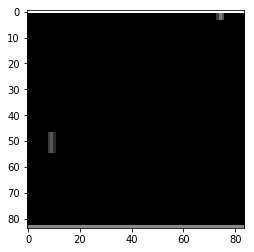

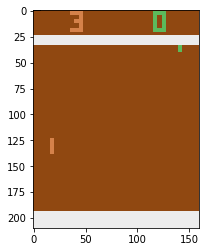

In [23]:
act = act_idle
# act = act_up
# act = act_down
obs, reward, is_term, _ = env.step(act)
print('Reward: {}, terminal?: {}'.format(reward, is_term))
show(preprocess(obs))
show(obs)

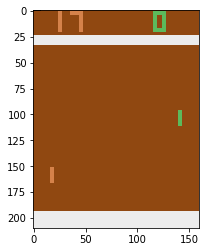

In [185]:
show(obs)